In [9]:
from nltk.tokenize import word_tokenize
import numpy as np
from tensorflow import keras

Below is the import and define of GloVe, takes a while but once it's done we dont need to repeat it. <br>
!!!!!!!!!!!!!!!!!!!!!!!!<br>Make sure your file address for this code contains "glove.6B.50d.txt"<br>
If not, get it with Google Drive or https://nlp.stanford.edu/projects/glove/ 

In [10]:
def glove():
    # Glove vector contains a 50 dimensional vector corresponding 
    # to each word in dictionary.
    vocab_f = 'glove.6B.50d.txt'
 
    # embeddings_index is a dictionary which contains the mapping of
    # word with its corresponding 50d vector.
    embeddings_index = {}
    with open(vocab_f, encoding='utf8') as f:
        for line in f:
            # splitting each line of the glove.6B.50d in a list of 
            # items- in which the first element is the word to be embedded,
            # and from second to the end of line contains the 50d vector.
            values = line.rstrip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = glove()

Define the processing of input and function for prediction, pretty much the same as the FirstCode_DBM140

In [11]:
class Usertest:
    def __init__(self):
        self.user_input = []

    def lower_texts(self,user_input):
        # Each  sentence in feel_arr is tokenized by the help of work tokenizer.
        # If I have a sentence - 'I am happy'. 
        # After word tokenizing it will convert into- ['I','am','happy']
        lower_texts = [word_tokenize(sent.lower()) for sent in user_input]
        return lower_texts
    
    def padding (self,lower_texts):
        # Defined a function padd in which each sentence length is fixed to 200.
        # If length is less than 200 , then the word- '<padd>' is append
        def padd(arr):
            for i in range(200-len(arr)):
                arr.append('<pad>')
            return arr[:200]
        # call the padd function for each sentence in feel_arr
        for i in range(len(lower_texts)):
            lower_texts[i]=padd(lower_texts[i])
        return lower_texts


    def embedding (self,lower_texts,embeddings_index):
        # Embedding each word of the feel_arr
        embedding_texts = []
        # Iterate through each sub-list (sentences)
        for word_list in lower_texts:
            # Initialize an empty list to store the embedding vectors for each word
            word_vectors = []
            for word in word_list:
                if word in embeddings_index:
                    word_vector = embeddings_index[word]
                    word_vectors.append(word_vector)
                else:
                    # if the word to be embedded is '<padd>' append 0 fifty times
                    word_vector = np.zeros(50, dtype='float32')
                    word_vectors.append(word_vector)
            embedding_texts.append(word_vectors)
            X = np.array(embedding_texts)
        return  X

    def importmodel (self,path):
        model = keras.models.load_model(path)
        return model
    
    def predict (self,model,X):
        prediction = model.predict(X,verbose=0)
        return prediction
    



    def run(self,user_input,embeddings_index,path):
        lower_texts = self.lower_texts(user_input)
        lower_texts = self.padding(lower_texts)
        X = self.embedding (lower_texts,embeddings_index)

        model = self.importmodel (path)
        prediction = self.predict(model,X)
        return prediction


    

    

!!!!!!!!!!!!!!!!!!!!<br>
Below is the Code for attention layer only, if you dont have attention in the model you can skip this part<br>
model with atttention layer is always ended in .keras, while rugular model ended with .h5<br>
!!!!!!!!!!!!!!!!!!!!

In [12]:
from tensorflow.keras.layers import Layer, Bidirectional, LSTM, Input, Dense
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K


@keras.saving.register_keras_serializable()
class Attention(Layer):
    def __init__(self, attention_size, **kwargs):
        self.attention_size = attention_size
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # W: (EMBED_SIZE, ATTENTION_SIZE)
        # b: (ATTENTION_SIZE, 1)
        # u: (ATTENTION_SIZE, 1)
        self.W = self.add_weight(name="W_{:s}".format(self.name),
                                 shape=(input_shape[-1], self.attention_size),
                                 initializer="glorot_normal",
                                 trainable=True)
        self.b = self.add_weight(name="b_{:s}".format(self.name),
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(name="u_{:s}".format(self.name),
                                 shape=(self.attention_size, 1),
                                 initializer="glorot_normal",
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x, mask=None):
        # input: (BATCH_SIZE, MAX_TIMESTEPS, EMBED_SIZE)
        # et: (BATCH_SIZE, MAX_TIMESTEPS, ATTENTION_SIZE)
        et = K.tanh(K.dot(x, self.W) + self.b)
        # at: (BATCH_SIZE, MAX_TIMESTEPS)
        at = K.softmax(K.squeeze(K.dot(et, self.u), axis=-1))
        if mask is not None:
            at *= K.cast(mask, K.floatx())
        # ot: (BATCH_SIZE, MAX_TIMESTEPS, EMBED_SIZE)
        atx = K.expand_dims(at, axis=-1)
        ot = atx * x
        # output: (BATCH_SIZE, EMBED_SIZE)
        output = K.sum(ot, axis=1)
        return output

    def compute_mask(self, input, input_mask=None):
        return None

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [13]:
user = Usertest()

===================================================================

Once every codes above was runned, you can repeat the box below to test repeatly for users.
-------------------------------------------------------------------------------------------
Belew request for user input (text message), it will predict the emotion with the model.<br>
The only thing you need to change is the file name for model. (e.g. 'trained_model_Sikai_20231020_1.keras')

In [14]:
a = input("please input your words：")
user_inputs = [a]
prediction = user.run(user_inputs,embeddings_index,'trained_model_Sikai_20231020_1.keras')

Below offers two ways for prediciton visualization: <br>
1. Only showing one emotion with the biggest possiblity.

In [15]:

# Find the index of the largest value
max_index = np.argmax(prediction)

# Define a list of emotion tags
emotion_labels = ["fear", "guilt", "joy", "sadness", "shame"]

# Find the corresponding emotional label
predicted_emotion = emotion_labels[max_index]

print(f"For your message: '{a}'")
print(f"The most likely emotion is: {predicted_emotion}")

For your message: 'The weather is terrible these days in Eindhoven'
The most likely emotion is: sadness


2. I created a pie Chart to visulize the distrubution of emotions <br>
Be aware that the percentage is only the possiblity of the prediction, it's not how much emotion the message has. <br>
For example, if we have a prediciton with sad for 40% and joy for 50%, it only means the model think it is likely to be either joy or sad.<br>
It does not mean the message has a combination emotions of both joy and sad.

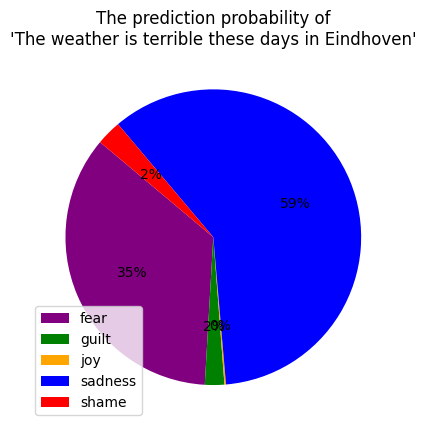

In [16]:
import matplotlib.pyplot as plt

labels = ["fear", "guilt", "joy", "sadness", "shame"]
colors = ['purple', 'green', 'orange', 'blue', 'red']

# Creating Pie Charts
plt.pie(prediction[0],  autopct='%d%%', startangle=140,colors=colors)



title_text = f"The prediction probability of\n'{a}'"
plt.title(title_text)

plt.legend(labels, loc='best')

plt.show()